In [1]:
from word_mover_distance import model
import torchtext.vocab as vocab
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import re
import matplotlib.pyplot as plt
from nltk import download
from nltk.corpus import stopwords
import torch
import bert_score

/Users/philippmetzger/anaconda3/envs/tm_pip_3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Load data

In [13]:
path_corpus = "/Users/philippmetzger/OneDrive/PHILIPP/NOVA IMS/2nd Semester/06 Text Mining 4 ECTS/00 Project/corpus/"
cs_en = pd.read_csv(path_corpus + "cs-en/scores.csv")
de_en = pd.read_csv(path_corpus + "de-en/scores.csv")
en_fi = pd.read_csv(path_corpus + "en-fi/scores.csv")
en_zh = pd.read_csv(path_corpus + "en-zh/scores.csv")
ru_en = pd.read_csv(path_corpus + "ru-en/scores.csv")
zh_en = pd.read_csv(path_corpus + "zh-en/scores.csv")

In [14]:
data_list = [cs_en, de_en, en_fi, en_zh, ru_en, zh_en]
names_list = ['cs_en', 'de_en', 'en_fi', 'en_zh', 'ru_en', 'zh_en']

In [15]:
descriptions = ["Russian into English", "German into English", "Czech into English", "Chinese into English", "English into Chinese", "English into Finish"]

rows = []
zscores = []
avgscores = []
annots = []

i = 0

for element in [ru_en, de_en, cs_en, zh_en, en_zh, en_fi]:
    rows.append(element.shape[0])
    zscores.append(np.round(element["z-score"].mean(),2))
    avgscores.append(np.round(element["avg-score"].mean(), 2))
    annots.append(np.round(element["annotators"].mean(),2))
    i += 1                   
    
exploration_df = pd.DataFrame([rows, zscores, avgscores, annots]).T.rename(columns={0:"rows", 1:"avg z-score", 2:"avg avg-score", 3:"avg annotators"})
exploration_df["description"] = descriptions
exploration_df = exploration_df.set_index("description")
exploration_df

,rows,avg z-score,avg avg-score,avg annotators
description,,,,
Russian into English,17980.0,0.01,74.50,1.30
German into English,21704.0,0.00,71.85,1.50
Czech into English,11585.0,-0.03,69.24,1.89
Chinese into English,26419.0,-0.05,66.06,1.42
English into Chinese,10221.0,-0.06,65.98,1.58
English into Finish,6748.0,-0.14,45.12,1.23


In [16]:
data_list[3].head()

,source,reference,translation,z-score,avg-score,annotators
0,"""In the GISS model's simulation, Venus' slow s...",GSIS的科学家AnthonyDelGenio在新闻稿中解释说：“在GISS模型的模拟模型中...,戈达德太空研究所科学家安东尼·德尔·杰尼奥在新闻发布会上解释说：“在戈达德太空研究所的模型模...,-1.171867,50.0,1
1,Ai Yanhan of China in the Women's 4 x 200m Fre...,中国在英国女性4x200mFreestreyWTE中的最后被称为：“中国14岁的孩子从球下降...,参加女子4x200米自由泳接力赛决赛的中国小将艾衍含被这样描述：“那名14岁的中国小姑娘犯了...,-2.255403,26.5,2
2,"Then came 2012, when nothing much went right f...",然后来到2012年，当她和她的队友们没有什么好处。,2012年，她和她的队友都不被看好。,-2.508996,21.0,1
3,"Since last year, Guodian Group has exported a ...",自去年以来，GoudianGroup从南非通过南非港口出口了163套风力发电项目。,自去年以来，国电集团共计有163套风电项目陆续从连云港港出口南非。,-2.416780,23.0,1
4,"Some alleged that the Kempinski hotel simply ""...","一些人指称，Kempinski旅馆只是""被捕""，以满足阿拉伯客户的要求。",有人认为凯宾斯基酒店简直是为了满足阿拉伯客户的要求而“卑躬屈膝”。,-1.489676,45.0,7


In [6]:
if False:
    list_reference = []
    list_translation = []

    for item in data_list[3]['reference']:
        item = list(item)
        item = ' '.join(item)
        list_reference.append(item)

    for item in data_list[3]['translation']:
        item = list(item)
        item = ' '.join(item)
        list_translation.append(item)

    data_list[3]['reference'] = list_reference
    data_list[3]['translation'] = list_translation

In [17]:
data_list[3]['reference']

0        GSIS的科学家AnthonyDelGenio在新闻稿中解释说：“在GISS模型的模拟模型中...
1        中国在英国女性4x200mFreestreyWTE中的最后被称为：“中国14岁的孩子从球下降...
2                                然后来到2012年，当她和她的队友们没有什么好处。
3                自去年以来，GoudianGroup从南非通过南非港口出口了163套风力发电项目。
4                     一些人指称，Kempinski旅馆只是"被捕"，以满足阿拉伯客户的要求。
                               ...                        
10216       这不是一个大型的会议，它不是皇家 Ascot -它是一个普通的星期五晚上，有20，000人。
10217    这位负责人强调，钢铁产品的国际贸易本质上是一种市场行为，是从进口国的要求和考虑产品成本和其他...
10218               她继续浏览，并最终在 Bouverie 广场购物中心的商店里尝试了四双内衣。
10219                 但是当他带着女儿参加综艺节目“爸爸，我们去哪里？”时，他成为了一个焦点。
10220           行业数据显示，2015年煤炭生产总量接近60亿吨，全国煤炭生产产能过剩达到18亿吨。
Name: reference, Length: 10221, dtype: object

In [18]:
data_list[3]['translation']

0        戈达德太空研究所科学家安东尼·德尔·杰尼奥在新闻发布会上解释说：“在戈达德太空研究所的模型模...
1        参加女子4x200米自由泳接力赛决赛的中国小将艾衍含被这样描述：“那名14岁的中国小姑娘犯了...
2                                       2012年，她和她的队友都不被看好。
3                        自去年以来，国电集团共计有163套风电项目陆续从连云港港出口南非。
4                        有人认为凯宾斯基酒店简直是为了满足阿拉伯客户的要求而“卑躬屈膝”。
                               ...                        
10216    这不是一场大规模的赛马会，也不是英国皇家爱斯科赛马会 (Royal Ascot)，这只是一个...
10217    这位负责人强调，钢铁产品国际贸易本质上讲是市场行为，是源于进口国需求、消费者综合考虑产品性价...
10218    她继续浏览货架，并最终在位于 Folkestone 的 Bouverie Place 购物中...
10219    但在2004年奥运会单人十米台比赛中输给队友胡佳后，田亮的竞技状态出现下滑，并被爆出被跳水队开除。
10220              行业数据显示，2015年煤炭产能总规模接近60亿吨，全国煤炭产能过剩18亿吨。
Name: translation, Length: 10221, dtype: object

# Naive implementation inspired by Word Mover's distance

In [9]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

In [10]:
glove = vocab.GloVe(name='6B', dim=50)
print('Loaded {} words'.format(len(glove.itos)))

Loaded 400000 words


In [7]:
distances = []

for i in tqdm(range(de_en.shape[0])):
    
    over = False

    a = de_en.iloc[i,1]
    b = de_en.iloc[i,2]

    a = a.lower()
    a = re.sub("[^a-z]", ' ', a)
    a = a.split()

    b = b.lower()
    b = re.sub("[^a-z]", ' ', b)
    b = b.split()

    # Uncommenting the following two lines worsens the correlation
    #a = [word for word in a if word not in stop]
    #b = [word for word in b if word not in stop]

    len_pre_oov1 = len(a)
    len_pre_oov2 = len(b)
    a = [token for token in a if token in glove.itos]
    b = [token for token in b if token in glove.itos]
    diff1 = len_pre_oov1 - len(a)
    diff2 = len_pre_oov2 - len(b)

    if len(a) == 0 or len(b) == 0:
        #print('At least one of the documents had no words that were in the vocabulary. Aborting (returning inf).')
        dist = -1
        over = True

    if not over:
        dist = 0
        for word_a in a:
            distances_this = []
            for word_b in b:

                distances_this.append(torch.dist(get_word(word_a), get_word(word_b)))

            min_dist = min(distances_this)

            dist += min_dist
    
    distances.append(dist)

max_dist = max(distances)
distances = [max_dist if dist == -1 else dist for dist in distances]

  0%|          | 0/21704 [00:00<?, ?it/s]

In [8]:
pearsonr(de_en['avg-score'], distances)[0]

-0.1648361559689596

-0.1648361559689596

In [9]:
kendalltau(de_en['avg-score'], distances)[0]

-0.1396207216132029

-0.1396207216132029

# Word mover's distance
https://pypi.org/project/word-mover-distance/#description

In [49]:
#!pip install word-mover-distance

## Convert the embedding model into a dictionary and pass it to word_mover_distance

In [11]:
glove_dict = {}

for i in range(len(glove.vectors)):
    glove_dict[glove.itos[i]] = glove.vectors[i].numpy()

In [12]:
my_model = model.WordEmbedding(model=glove_dict)

## Test word_mover_distance

In [15]:
s1 = 'Obama speaks to the media in Chicago'.lower().split()
s2 = 'The president spoke to the press in Chicago'.lower().split()
wmdistance = my_model.wmdistance(s1, s2)
wmdistance

1.8119693993679309

1.8119693993679309

## Use word_mover_distance on our data

### Version 1: With stopword removal

In [13]:
stop = stopwords.words('english')

In [14]:
data = de_en

wmdistances = []

for row in tqdm(range(data.shape[0])):
    
    s1 = data.iloc[row,1]
    s2 = data.iloc[row,2]
    
    s1 = s1.lower()
    s1 = re.sub("[^a-z]", ' ', s1)
    s1 = s1.split()
    
    s2 = s2.lower()
    s2 = re.sub("[^a-z]", ' ', s2)
    s2 = s2.split()
    
    s1 = [word for word in s1 if word not in stop]
    s2 = [word for word in s2 if word not in stop]
    
    wmdistance = my_model.wmdistance(s1, s2)
    wmdistances.append(wmdistance)

  0%|          | 0/21704 [00:00<?, ?it/s]

#### Replace inf values by maximum

In [15]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]
max_dist = max(wmdistances2)
wmdistances2 = [max_dist if dist == -1 else dist for dist in wmdistances2]

In [16]:
pearsonr(de_en['avg-score'], wmdistances2)[0]

-0.27926436711081465

-0.27926436711081465

In [17]:
kendalltau(de_en['avg-score'], wmdistances2)[0]

-0.20792525828577252

-0.20792525828577252

#### Replace inf values by maximum/2

In [18]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]

wmdistances2 = [(max_dist/2) if dist == -1 else dist for dist in wmdistances2]

In [19]:
pearsonr(de_en['avg-score'], wmdistances2)[0]

-0.2931366960034692

-0.2931366960034692

In [20]:
kendalltau(de_en['avg-score'], wmdistances2)[0]

-0.2081883157171871

In [6]:
-0.2081883157171871

-0.2081883157171871

### Version 2: Without stopword removal

In [11]:
data = de_en

wmdistances = []

for row in tqdm(range(data.shape[0])):
    
    s1 = data.iloc[row,1]
    s2 = data.iloc[row,2]
    
    s1 = s1.lower()
    s1 = re.sub("[^a-z]", ' ', s1)
    s1 = s1.split()
    
    s2 = s2.lower()
    s2 = re.sub("[^a-z]", ' ', s2)
    s2 = s2.split()
    
    wmdistance = my_model.wmdistance(s1, s2)
    wmdistances.append(wmdistance)

  0%|          | 0/21704 [00:00<?, ?it/s]

#### Replace inf values by maximum

In [22]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]
max_dist = max(wmdistances2)
wmdistances2 = [max_dist if dist == -1 else dist for dist in wmdistances2]

In [23]:
pearsonr(de_en['avg-score'], wmdistances2)[0]

-0.30853318447232847

In [24]:
kendalltau(de_en['avg-score'], wmdistances2)[0]

-0.2168328261851982

#### Replace inf values by maximum/2

In [57]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]

wmdistances2 = [(max_dist/2) if dist == -1 else dist for dist in wmdistances2]

In [26]:
pearsonr(de_en['avg-score'], wmdistances2)[0]

-0.30882340005334613

-0.30882340005334613

In [27]:
kendalltau(de_en['avg-score'], wmdistances2)[0]

-0.2168229814123602

-0.2168229814123602

#### Find optimal q for replacing inf values by maximum/q

In [30]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]
max_dist = max(wmdistances2)

Ps = []
Ks = []

for q in np.arange(1,10.1,0.1):
    wmdistances3 = [(max_dist/q) if dist == -1 else dist for dist in wmdistances2]
    p = pearsonr(de_en['avg-score'], wmdistances3)[0]
    k = kendalltau(de_en['avg-score'], wmdistances3)[0]
    Ps.append(p)
    Ks.append(k)

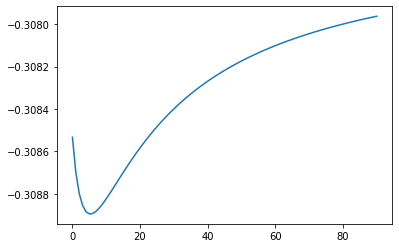

In [31]:
plt.plot(Ps)

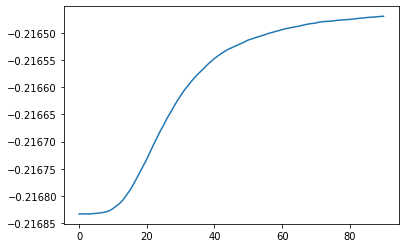

In [32]:
plt.plot(Ks)

In [44]:
temp = min(Ps)
opt_index = [i for i, j in enumerate(Ps) if j == temp]
opt_index

[5]

In [45]:
np.arange(1,10.1,0.1)[opt_index]

array([1.5])

In [46]:
Ps[opt_index[0]]

-0.3088945388262984

## With q=1.5 and all language pairs

In [19]:
for i, data in enumerate(data_list):

    wmdistances = []

    for row in tqdm(range(data.shape[0])):

        s1 = data.iloc[row,1]
        s2 = data.iloc[row,2]

        s1 = s1.lower()
        s1 = re.sub("[^a-z]", ' ', s1)
        s1 = s1.split()

        s2 = s2.lower()
        s2 = re.sub("[^a-z]", ' ', s2)
        s2 = s2.split()

        wmdistance = my_model.wmdistance(s1, s2)
        wmdistances.append(wmdistance)
        
    wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]
    
    max_dist = max(wmdistances2)

    wmdistances2 = [(max_dist/1.5) if dist == -1 else dist for dist in wmdistances2]
    
    print(names_list[i])

    print('Pearson:', pearsonr(data['z-score'], wmdistances2)[0])

    print('Kendall:', kendalltau(data['z-score'], wmdistances2)[0])

  0%|          | 0/11585 [00:00<?, ?it/s]

cs_en
Pearson: -0.46030126797586646
Kendall: -0.30940181633936314


  0%|          | 0/21704 [00:00<?, ?it/s]

de_en
Pearson: -0.3471321877208495
Kendall: -0.23635952775834046


  0%|          | 0/6748 [00:00<?, ?it/s]

en_fi
Pearson: -0.34750622916088814
Kendall: -0.23649325036411972


  0%|          | 0/10221 [00:00<?, ?it/s]

en_zh
Pearson: -0.00335960895263772
Kendall: 0.010059931927933443


  0%|          | 0/17980 [00:00<?, ?it/s]

ru_en
Pearson: -0.35268581593319714
Kendall: -0.23904526297449227


  0%|          | 0/26419 [00:00<?, ?it/s]

zh_en
Pearson: -0.34486008737468143
Kendall: -0.22740271858832356


In [14]:
for i, data in enumerate(data_list):

    wmdistances = []

    for row in tqdm(range(data.shape[0])):

        s1 = data.iloc[row,1]
        s2 = data.iloc[row,2]

        s1 = s1.lower()
        s1 = re.sub("[^a-z]", ' ', s1)
        s1 = s1.split()

        s2 = s2.lower()
        s2 = re.sub("[^a-z]", ' ', s2)
        s2 = s2.split()

        wmdistance = my_model.wmdistance(s1, s2)
        wmdistances.append(wmdistance)
        
    wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]
    
    max_dist = max(wmdistances2)

    wmdistances2 = [(max_dist/1.5) if dist == -1 else dist for dist in wmdistances2]
    
    print(names_list[i])

    print('Pearson:', pearsonr(data['avg-score'], wmdistances2)[0])

    print('Kendall:', kendalltau(data['avg-score'], wmdistances2)[0])

  0%|          | 0/11585 [00:00<?, ?it/s]

cs_en
Pearson: -0.42960280668318424
Kendall: -0.2943086361107622


  0%|          | 0/21704 [00:00<?, ?it/s]

de_en
Pearson: -0.3088945388262984
Kendall: -0.21683194616228435


  0%|          | 0/6748 [00:00<?, ?it/s]

en_fi
Pearson: -0.327685921486173
Kendall: -0.22875147029027298


  0%|          | 0/10221 [00:00<?, ?it/s]

en_zh
Pearson: -0.006933625120976233
Kendall: 0.006414615972311196


  0%|          | 0/17980 [00:00<?, ?it/s]

ru_en
Pearson: -0.30654752716016337
Kendall: -0.2136593066443208


  0%|          | 0/26419 [00:00<?, ?it/s]

zh_en
Pearson: -0.2972245166797449
Kendall: -0.19566544617853907


cs_en
Pearson: -0.4302867109402357
Kendall: -0.2946087295081448

de_en
Pearson: -0.3082085182870933
Kendall: -0.21652481793587566

en_fi
Pearson: -0.3585093522404916
Kendall: -0.2424647181157597

en_zh
Pearson: -0.05633962440065445
Kendall: -0.04644650615293067

ru_en
Pearson: -0.30558847639136544
Kendall: -0.21335539304562018

zh_en
Pearson: -0.2973579205432469
Kendall: -0.19579630984661323

# Using Embedding word2vec-google-news-300
https://code.google.com/archive/p/word2vec/

In [6]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

vec_king = wv['king']

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [36]:
s1 = 'Obama speaks to the media in Chicago'.lower().split()
s2 = 'The president spoke to the press in Chicago'.lower().split()

In [37]:
wv.wmdistance(s1,s2)

0.5936775775354225

In [39]:
data = de_en

wmdistances = []

for row in tqdm(range(data.shape[0])):
    
    s1 = data.iloc[row,1]
    s2 = data.iloc[row,2]
    
    s1 = s1.lower()
    s1 = re.sub("[^a-z]", ' ', s1)
    s1 = s1.split()
    
    s2 = s2.lower()
    s2 = re.sub("[^a-z]", ' ', s2)
    s2 = s2.split()
    
    wmdistance = wv.wmdistance(s1, s2)
    wmdistances.append(wmdistance)

  0%|          | 0/21704 [00:00<?, ?it/s]

In [44]:
min(wmdistances)

0.0

In [45]:
max(wmdistances)

inf

In [50]:
wmdistances2 = [-1 if dist == np.inf else dist for dist in wmdistances]
max_dist = max(wmdistances2)

Ps = []
Ks = []

for q in np.arange(1,10.1,0.1):
    wmdistances3 = [(max_dist/q) if dist == -1 else dist for dist in wmdistances2]
    p = pearsonr(de_en['avg-score'], wmdistances3)[0]
    k = kendalltau(de_en['avg-score'], wmdistances3)[0]
    Ps.append(p)
    Ks.append(k)

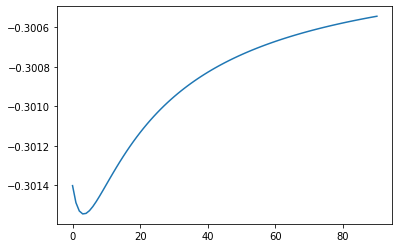

In [51]:
plt.plot(Ps)

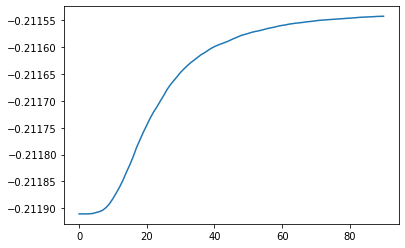

In [52]:
plt.plot(Ks)

In [53]:
temp = min(Ps)
opt_index = [i for i, j in enumerate(Ps) if j == temp]
opt_index

[3]

In [54]:
np.arange(1,10.1,0.1)[opt_index]

array([1.3])

In [55]:
Ps[opt_index[0]]

-0.3015451610466434

# BERTScore
https://pypi.org/project/bert-score/

In [48]:
#!pip install bert-score

In [1]:
from bert_score import score

In [ ]:
# Kernes dies when running this

s1 = ['Obama speaks to the media in Chicago'.lower()]
s2 = ['The president spoke to the press in Chicago'.lower()]

P, R, F1 = score(cands, refs, lang="en", verbose=True)